In [1]:
import sys
sys.path.append('../../..')

import numpy as np

from olfactory_navigation.environment import Environment
from olfactory_navigation.agents import FSVI_Agent
from olfactory_navigation.agents.model_based_util.pomdp import Model
from olfactory_navigation.simulation import run_test
from olfactory_navigation.test_setups import run_all_starts_test

from matplotlib import pyplot as plt
from matplotlib import colors, patches
from scipy.stats import multivariate_normal
from sklearn.metrics import confusion_matrix

In [2]:
from model_7 import generate_model

In [3]:
from cupy.cuda import runtime as cuda_runtime
cuda_runtime.setDevice(1)

## Variables

In [4]:
space_shape = np.array([101,101])
cells = np.array([5,5])

source_radius = 2
source_cell_resolution = np.array([5,5])

data_mean = [50,50]
data_covariance = 50

## Model

In [5]:
model = generate_model(
    space_shape=space_shape,
    cells=cells,
    source_radius=source_radius,
    source_cell_resolution=source_cell_resolution,
    data_mean=data_mean,
    data_covariance=data_covariance
)

## Agent

In [6]:
def generate_fake_data(
        space_shape: np.ndarray,
        data_mean: list,
        data_covariance,
        samples: int
        ) -> np.ndarray:
    x,y = np.meshgrid(np.arange(space_shape[0]), np.arange(space_shape[1]))
    pos = np.dstack((x, y))
    rv = multivariate_normal(data_mean, data_covariance)
    probability_map = rv.pdf(pos)

    # Normalize to have 1 at the center
    probability_map /= np.max(probability_map)

    multiple_samples = (np.random.random((samples, *space_shape)) < probability_map).astype(float)

    return multiple_samples

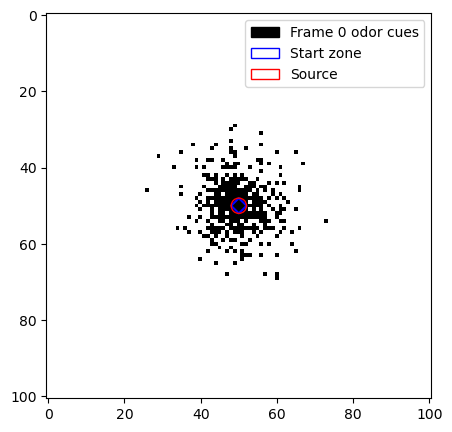

In [7]:
artificial_data = generate_fake_data(space_shape=space_shape,
                                     data_mean=data_mean,
                                     data_covariance=data_covariance,
                                     samples=1000)

artificial_env  = Environment(data_file=artificial_data,
                              data_source_position=[50, 50],
                              source_radius=source_radius,
                              shape=space_shape,
                              boundary_condition='stop',
                              start_zone='data_zone',
                              odor_present_threshold=3e-1)

artificial_env.plot()

In [8]:
ag = FSVI_Agent(environment=artificial_env,
                threshold=3e-8,
                space_aware=True,
                spacial_subdivisions=cells,
                model=model)

In [9]:
_ = ag.train(expansions=300, use_gpu=True)

[09/26/2024, 14:57:31] MDP_policy, not provided. Solving MDP with Value Iteration...
[09/26/2024, 14:57:31] Sending Model to GPU...
[09/26/2024, 14:57:31]     > Done in 0.225s


  0%|          | 0/1000 [00:00<?, ?it/s]

Summary of Value Iteration run
  - Model: 1251-state, 4-action
  - Converged in 918 iterations and 1.4315 seconds
  - Took on average 0.0016s per iteration


Expansions:   0%|          | 0/300 [00:00<?, ?it/s]

Summary of Point Based Value Iteration run
  - Model: 1251 state, 4 action, 51 observations
  - Converged or stopped after 300 expansion steps and 300 backup steps.
  - Resulting value function has 2892 alpha vectors.
  - Converged in 51.3499s

  - Expand function took on average 0.0141s and yielded on average 1190.66 beliefs per iteration. (0.0001s/it/belief)
  - Backup function took on average 0.1571s and yielded on average 9.63 alpha vectors per iteration. (0.0001s/it/alpha)
  - Pruning function took on average 0.0000s and yielded on average prunings of 0.00 alpha vectors per iteration.


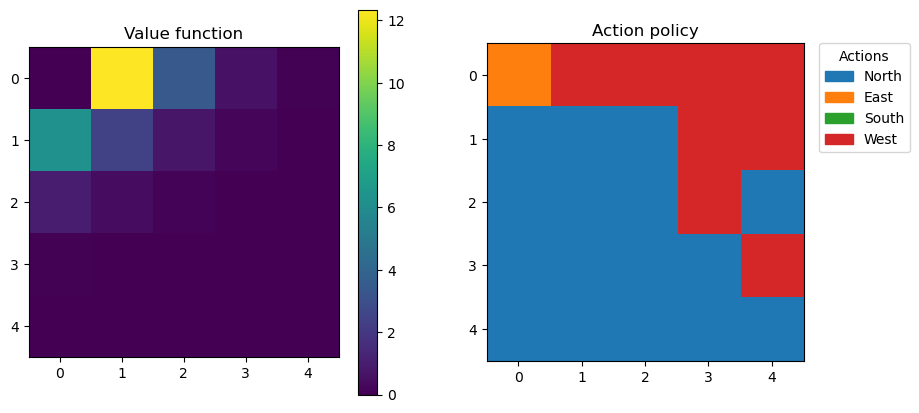

In [10]:
# CUSTOM PLOT
COLOR_LIST = [{
    'name': item.replace('tab:',''),
    'id': item,
    'hex': value,
    'rgb': [int(value.lstrip('#')[i:i + (len(value)-1) // 3], 16) for i in range(0, (len(value)-1), (len(value)-1) // 3)]
    } for item, value in colors.TABLEAU_COLORS.items()] # type: ignore

COLOR_ARRAY = np.array([c['rgb'] for c in COLOR_LIST])

# VF
vf = ag.value_function
new_shape = cells

# ! Select here which source to plot
source_policy = [0,0]
source_policy_id = np.arange(np.prod(cells)).reshape(cells)[*source_policy]
source_state_start = source_policy_id * np.prod(cells)

value_table = np.max(vf.alpha_vector_array, axis=0)[vf.model.state_grid[:,source_state_start:source_state_start+np.prod(cells)]].reshape(new_shape)
best_action_table = np.array(vf.actions)[np.argmax(vf.alpha_vector_array, axis=0)][vf.model.state_grid[:,source_state_start:source_state_start+np.prod(cells)]].reshape(new_shape)
best_action_colors = COLOR_ARRAY[best_action_table]

dimensions = new_shape

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(5*2, 5), width_ratios=(0.55,0.45))

# Ticks
x_ticks = np.arange(0, dimensions[1], (1 if dimensions[1] < 10 else int(dimensions[1] / 10)))
y_ticks = np.arange(0, dimensions[0], (1 if dimensions[0] < 5 else int(dimensions[0] / 5)))

ax1.set_title('Value function')
ax1_plot = ax1.imshow(value_table)

if dimensions[0] >= dimensions[1]: # If higher than wide
    plt.colorbar(ax1_plot, ax=ax1)
else:
    plt.colorbar(ax1_plot, ax=ax1, location='bottom', orientation='horizontal')

ax1.set_xticks(x_ticks)
ax1.set_yticks(y_ticks)

ax2.set_title('Action policy')
ax2.imshow(best_action_colors)
p = [ patches.Patch(color=COLOR_LIST[int(i)]['id'], label=str(vf.model.action_labels[int(i)])) for i in vf.model.actions]
ax2.legend(handles=p, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title='Actions')
ax2.set_xticks(x_ticks)
ax2.set_yticks(y_ticks)

plt.show()

### Validation on the artificial data

In [11]:
hist = run_all_starts_test(ag,
                           horizon=1000,
                           use_gpu=True)

  0%|          | 0/1000 [00:00<?, ?it/s]

Simulations done in 6.896s:
Simulations reached goal: 10188/10188 (0 failures (reached horizon: 0)) (100.00% success)
 - Average step count:                 235.416 +- 131.48 (Successful only: 235.416 +- 131.48)
 - Extra steps:                        186.859 +- 125.74 (Successful only: 186.859 +- 125.75)
 - Average discounted rewards (ADR):   0.178 +- 0.19 (Successful only: 0.178 +- 0.19)
 - Tmin/T:                             0.258 +- 0.15 (Successful only: 0.258 +- 0.15)


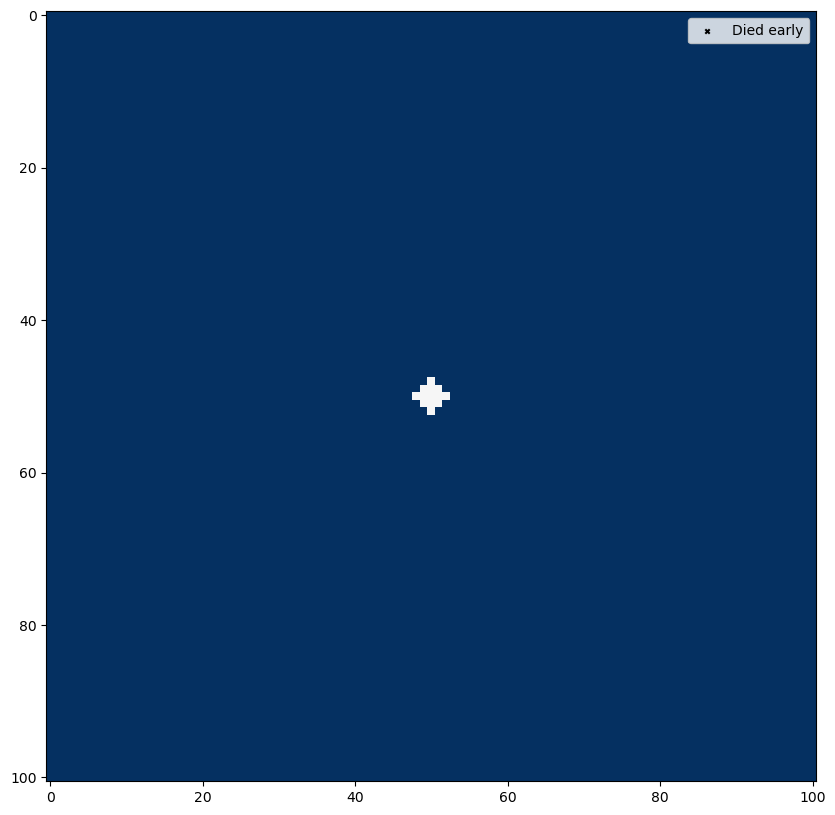

In [12]:
_, ax = plt.subplots(1,1, figsize=(10,10))
hist.plot_successes(ax)

## Test

In [13]:
shift = np.array([-49,-49])

shifted_artificial_data = np.zeros(artificial_data.shape)
trimmed_artificial_data = artificial_data[:, *[slice(0, -s) if s > 0 else slice(-s, shape) for shape, s in zip(space_shape, shift)]]
shifted_artificial_data[:, *[slice(s, shape) if s >=0 else slice(0, s) for shape, s in zip(space_shape, shift)]] = trimmed_artificial_data

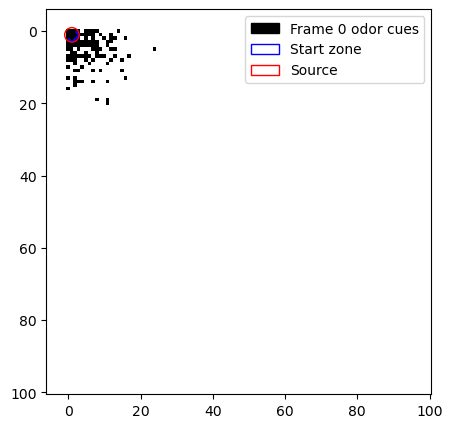

In [14]:
shifted_artificial_env  = Environment(data_file=shifted_artificial_data,
                                      data_source_position=(np.array([50,50]) + shift).tolist(),
                                      source_radius=source_radius,
                                      shape=space_shape,
                                      boundary_condition='stop',
                                      start_zone='data_zone',
                                      odor_present_threshold=3e-1)

shifted_artificial_env.plot()

In [15]:
hist = run_all_starts_test(ag,
                           environment=shifted_artificial_env,
                           horizon=1000,
                           use_gpu=True)

Using the provided environment, not the agent environment.


  0%|          | 0/1000 [00:00<?, ?it/s]

Simulations done in 18.268s:
Simulations reached goal: 88/10190 (10102 failures (reached horizon: 10102)) (0.86% success)
 - Average step count:                 991.666 +- 89.67 (Successful only: 34.977 +- 88.55)
 - Extra steps:                        895.522 +- 90.80 (Successful only: 26.409 +- 73.57)
 - Average discounted rewards (ADR):   0.007 +- 0.07 (Successful only: 0.778 +- 0.17)
 - Tmin/T:                             0.099 +- 0.05 (Successful only: 0.371 +- 0.23)


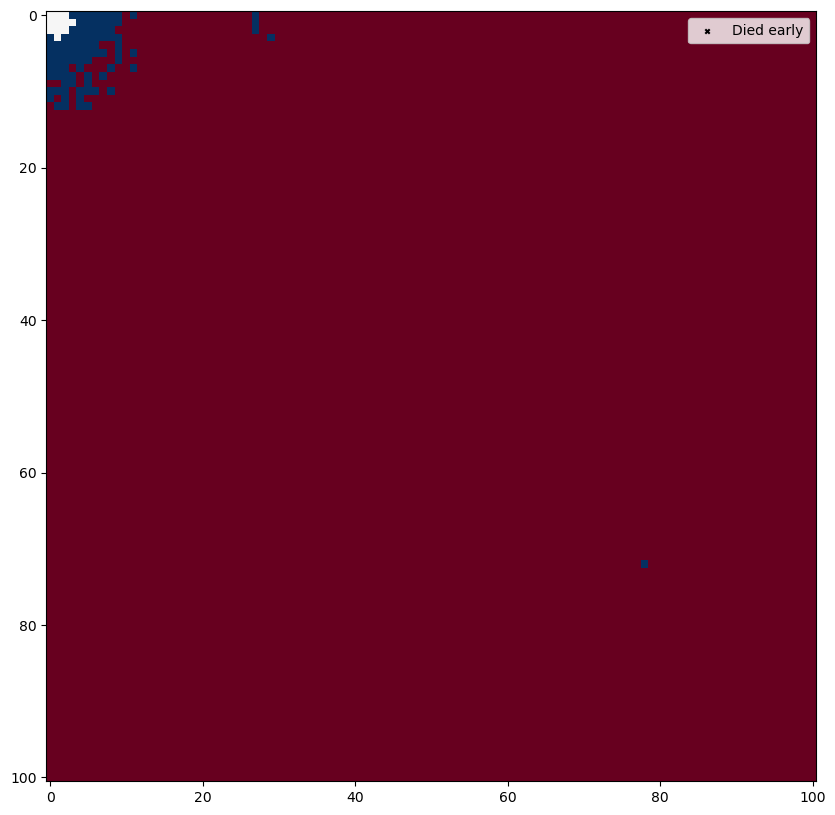

In [16]:
_, ax = plt.subplots(1,1, figsize=(10,10))
hist.plot_successes(ax)

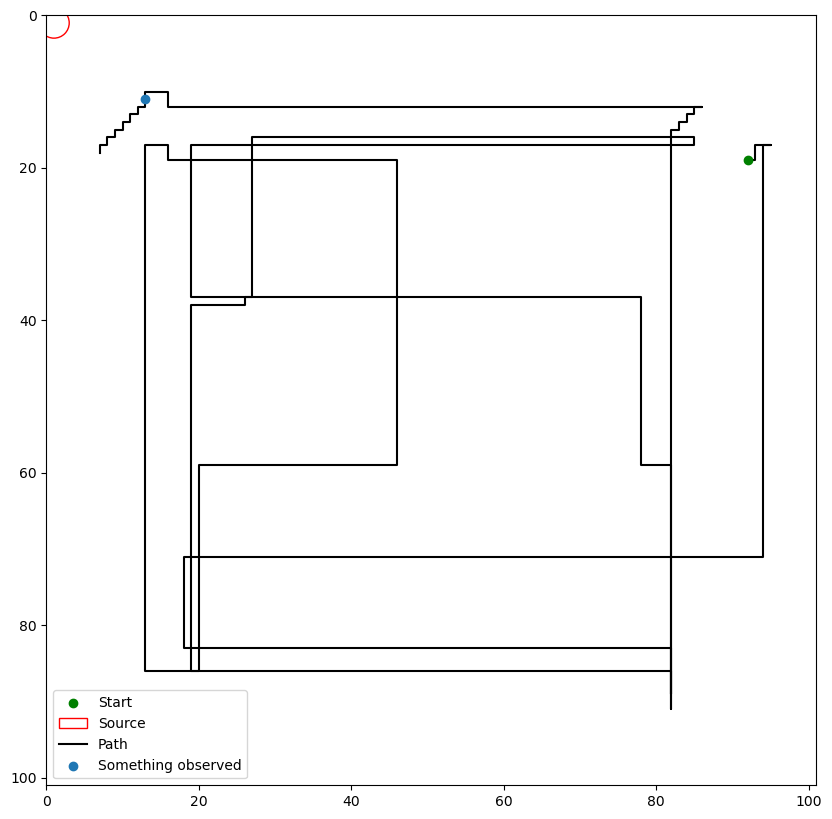

In [17]:
_, ax = plt.subplots(1,1, figsize=(10,10))
hist.plot(2000, ax=ax)

In [18]:
hist.analysis_df

,y,x,optimal_steps_count,converged,reached_horizon,steps_taken,discounted_rewards,extra_steps,t_min_over_t
mean,NaN,NaN,NaN,0.008636,0.991364,991.666143,0.006762,895.522277,0.099272
standard_deviation,NaN,NaN,NaN,0.092528,0.092528,89.665195,0.073670,90.803009,0.052029
success_mean,NaN,NaN,NaN,1.0,0.0,34.977273,0.778076,26.409091,0.370785
success_standard_deviation,NaN,NaN,NaN,0.0,0.0,88.545719,0.169352,73.565927,0.228541
run_0,0.0,3.0,1.0,True,False,5.000000,0.950990,4.000000,0.200000
...,...,...,...,...,...,...,...,...,...
run_10185,100.0,96.0,192.0,False,True,1000.000000,0.000043,808.000000,0.192000
run_10186,100.0,97.0,193.0,False,True,1000.000000,0.000043,807.000000,0.193000
run_10187,100.0,98.0,194.0,False,True,1000.000000,0.000043,806.000000,0.194000
run_10188,100.0,99.0,195.0,False,True,1000.000000,0.000043,805.000000,0.195000


## All Tests

In [19]:
# Complete test
all_hists = []
for i in range(1,50,2):
    shift = np.array([-i,-i])
    print(f'\n{shift = }')

    # Setup shifted environment
    shifted_artificial_data = np.zeros(artificial_data.shape)
    trimmed_artificial_data = artificial_data[:, *[slice(0, -s) if s > 0 else slice(-s, shape) for shape, s in zip(space_shape, shift)]]
    shifted_artificial_data[:, *[slice(s, shape) if s >=0 else slice(0, s) for shape, s in zip(space_shape, shift)]] = trimmed_artificial_data

    shifted_artificial_env  = Environment(data_file=shifted_artificial_data,
                                          data_source_position=(np.array([50,50]) + shift).tolist(),
                                          source_radius=source_radius,
                                          shape=space_shape,
                                          boundary_condition='stop',
                                          start_zone='data_zone',
                                          odor_present_threshold=3e-1)

    # Running test
    hist = run_all_starts_test(ag,
                               environment=shifted_artificial_env,
                               horizon=1000,
                               use_gpu=True,
                               print_progress=False)

    all_hists.append(hist)


shift = array([-1, -1])
Using the provided environment, not the agent environment.
Simulations done in 6.335s:
Simulations reached goal: 10188/10188 (0 failures (reached horizon: 0)) (100.00% success)
 - Average step count:                 231.017 +- 128.55 (Successful only: 231.017 +- 128.56)
 - Extra steps:                        182.439 +- 122.29 (Successful only: 182.439 +- 122.30)
 - Average discounted rewards (ADR):   0.184 +- 0.19 (Successful only: 0.184 +- 0.19)
 - Tmin/T:                             0.264 +- 0.15 (Successful only: 0.264 +- 0.15)

shift = array([-3, -3])
Using the provided environment, not the agent environment.
Simulations done in 6.937s:
Simulations reached goal: 10188/10188 (0 failures (reached horizon: 0)) (100.00% success)
 - Average step count:                 251.495 +- 134.42 (Successful only: 251.495 +- 134.42)
 - Extra steps:                        202.759 +- 127.72 (Successful only: 202.759 +- 127.73)
 - Average discounted rewards (ADR):   0.163 +- 

In [20]:
# Extracting performance metrics
convergences = []
convergences_std = []
tmin_over_ts = []
tmin_over_ts_std = []

for hist in all_hists:
    df = hist.analysis_df
    convergences.append(df['converged']['mean'])
    convergences_std.append(df['converged']['standard_deviation'])
    tmin_over_ts.append(df['t_min_over_t']['success_mean'])
    tmin_over_ts_std.append(df['t_min_over_t']['success_standard_deviation'])

Text(0.5, 0, 'Shift from center along diagonal')

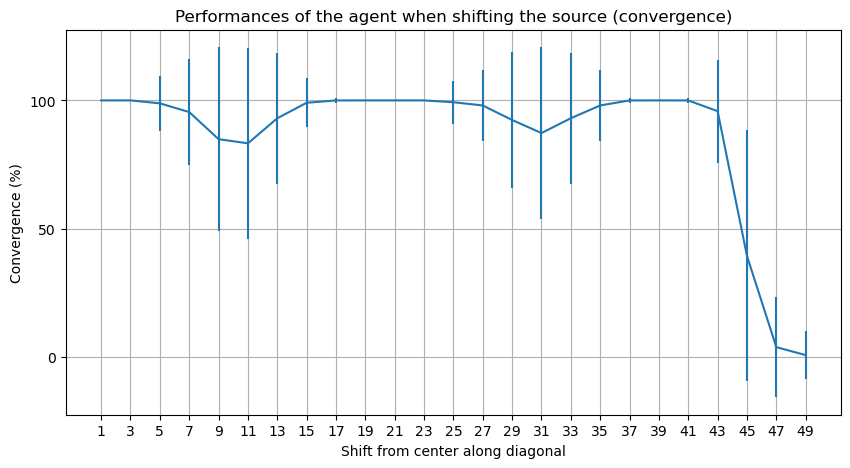

In [21]:
_, (ax0) = plt.subplots(1,1, figsize=(10,5), gridspec_kw={'hspace':0.3})
xs = (np.arange(len(convergences)) * 2) + 1

# Convergence plot
ax0.set_title('Performances of the agent when shifting the source (convergence)')
ax0.errorbar(xs, convergences, convergences_std)

# Other formatting
ax0.grid()
ax0.set_xticks(xs)
ax0.set_yticks([0.0, 0.5, 1.0], labels=[0, 50, 100])
ax0.set_ylabel('Convergence (%)')
ax0.set_xlabel('Shift from center along diagonal')

Text(0.5, 0, 'Shift from center along diagonal')

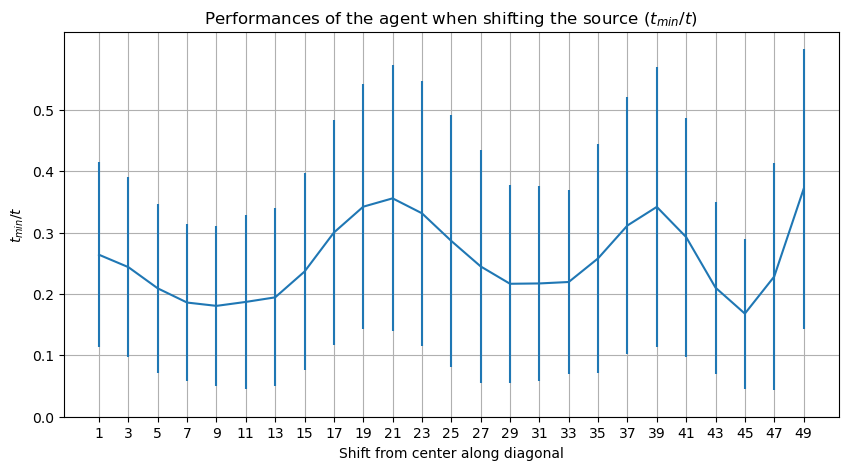

In [22]:
_, (ax1) = plt.subplots(1,1, figsize=(10,5), gridspec_kw={'hspace':0.3})

# tmin over t plot
ax1.set_title('Performances of the agent when shifting the source ($t_{min}/t$)')
ax1.errorbar(xs, tmin_over_ts, tmin_over_ts_std)

# Other formatting
ax1.grid()
ax1.set_xticks(xs)
ax1.set_yticks(np.arange(6)/10)
ax1.set_ylabel('$t_{min}/t$')
ax1.set_xlabel('Shift from center along diagonal')

## Grid check

In [23]:
point_array = np.array(list(np.ndindex(5,5))) * -2

print(f'{len(point_array) = }')

len(point_array) = 25


In [24]:
# Complete test
all_point_hists = []
for shift in point_array:
    print(f'\n{shift = }')

    # Setup shifted environment
    shifted_artificial_data = np.zeros(artificial_data.shape)
    trimmed_artificial_data = artificial_data[:, *[slice(0, -s) if s > 0 else slice(-s, shape) for shape, s in zip(space_shape, shift)]]
    shifted_artificial_data[:, *[slice(s, shape) if s >=0 else slice(0, s) for shape, s in zip(space_shape, shift)]] = trimmed_artificial_data

    shifted_artificial_env  = Environment(data_file=shifted_artificial_data,
                                          data_source_position=(np.array([50,50]) + shift).tolist(),
                                          source_radius=source_radius,
                                          shape=space_shape,
                                          boundary_condition='stop',
                                          start_zone='data_zone',
                                          odor_present_threshold=3e-1)

    # Running test
    hist = run_all_starts_test(ag,
                               environment=shifted_artificial_env,
                               horizon=1000,
                               use_gpu=True,
                               print_progress=False)

    all_point_hists.append(hist)


shift = array([0, 0])
Using the provided environment, not the agent environment.
Simulations done in 6.283s:
Simulations reached goal: 10188/10188 (0 failures (reached horizon: 0)) (100.00% success)
 - Average step count:                 235.416 +- 131.48 (Successful only: 235.416 +- 131.48)
 - Extra steps:                        186.859 +- 125.74 (Successful only: 186.859 +- 125.75)
 - Average discounted rewards (ADR):   0.178 +- 0.19 (Successful only: 0.178 +- 0.19)
 - Tmin/T:                             0.258 +- 0.15 (Successful only: 0.258 +- 0.15)

shift = array([ 0, -2])
Using the provided environment, not the agent environment.
Simulations done in 6.240s:
Simulations reached goal: 10188/10188 (0 failures (reached horizon: 0)) (100.00% success)
 - Average step count:                 229.280 +- 132.29 (Successful only: 229.280 +- 132.29)
 - Extra steps:                        180.683 +- 126.14 (Successful only: 180.683 +- 126.15)
 - Average discounted rewards (ADR):   0.189 +- 0.

In [25]:
# Extracting performance metrics
point_convergences = []
point_convergences_std = []
point_tmin_over_ts = []
point_tmin_over_ts_std = []

for hist in all_point_hists:
    df = hist.analysis_df
    point_convergences.append(df['converged']['mean'])
    point_convergences_std.append(df['converged']['standard_deviation'])
    point_tmin_over_ts.append(df['t_min_over_t']['success_mean'])
    point_tmin_over_ts_std.append(df['t_min_over_t']['success_standard_deviation'])

point_array_norm = (point_array * -1/2).astype(int)

point_convergences_array = np.zeros((5,5))
point_convergences_array[*point_array_norm.T] = point_convergences
point_convergences_std_array = np.zeros((5,5))
point_convergences_std_array[*point_array_norm.T] = point_convergences_std

point_tmin_over_ts_array = np.zeros((5,5))
point_tmin_over_ts_array[*point_array_norm.T] = point_tmin_over_ts
point_tmin_over_ts_std_array = np.zeros((5,5))
point_tmin_over_ts_std_array[*point_array_norm.T] = point_tmin_over_ts_std

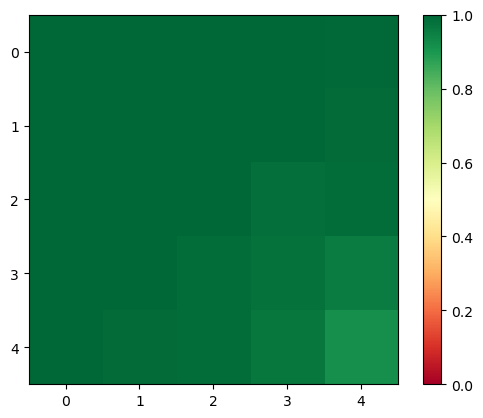

In [26]:
# Convergence plot
# plt.title('Performances of the agent when shifting the source (convergence)')
plt.imshow(point_convergences_array, cmap='RdYlGn', vmax=1.0, vmin=0.0)
plt.colorbar()
plt.show()

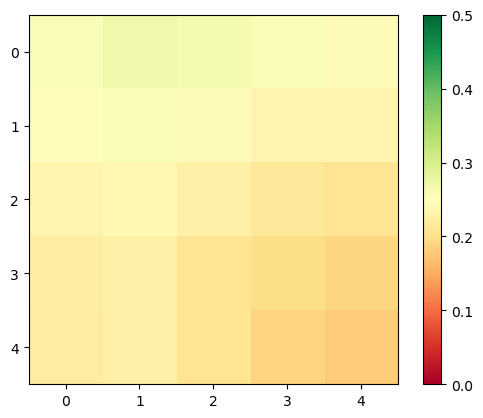

In [27]:
# Convergence plot
# plt.title('Performances of the agent when shifting the source ($t_{min}/t$)')
plt.imshow(point_tmin_over_ts_array, cmap='RdYlGn', vmax=0.5, vmin=0.0)
plt.colorbar()
plt.show()